In [12]:
import pandas
import numpy
import utils
import seaborn
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from itertools import product, combinations
!lscpu | head -n 17

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          8
On-line CPU(s) list:             0-7
Vendor ID:                       GenuineIntel
Model name:                      11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
CPU family:                      6
Model:                           140
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
Stepping:                        1
CPU(s) scaling MHz:              81%
CPU max MHz:                     4800.0000
CPU min MHz:                     400.0000


# Excercise 1

### Linear program
We say that two cities are adjacent if they are in range D of each other. \
A city is covered if at least one city with a store is adjacent to it. \
The objective is to find minimal placement of stores that covers every city.

In [25]:
def solve(adjacency_matrix, relaxed=False, verbose=False):
	vtype = GRB.CONTINUOUS if relaxed else GRB.BINARY

	model = gp.Model()
	cities = model.addVars(len(adjacency_matrix), vtype=vtype, lb=0.0, ub=1.0)

	model.setObjective(cities.sum(), GRB.MINIMIZE)

	for a in adjacency_matrix:
		model.addConstr(cities.prod(gp.tuplelist(a)) >= 1)

	model.Params.OutputFlag = verbose
	model.optimize()
	return model

### Solving integer formulation

In [14]:
coordinates, distances, cities = utils.load_dataset(frac=0.5, seed=123).values()
len(cities)

1459

In [15]:
%time model = solve(distances < 50, verbose=True)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Fedora Linux 36 (Workstation Edition)")

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1459 rows, 1459 columns and 73047 nonzeros
Model fingerprint: 0x9dc2816c
Variable types: 0 continuous, 1459 integer (1459 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 74.0000000
Presolve removed 489 rows and 398 columns
Presolve time: 0.21s
Presolved: 970 rows, 1061 columns, 37479 nonzeros
Found heuristic solution: objective 69.0000000
Variable types: 0 continuous, 1061 integer (1061 binary)

Root relaxation: objective 4.740519e+01, 2618 iterations, 0.24 seconds (0.33 work units)

    Nodes    |    Current Node    |     Objective Bounds

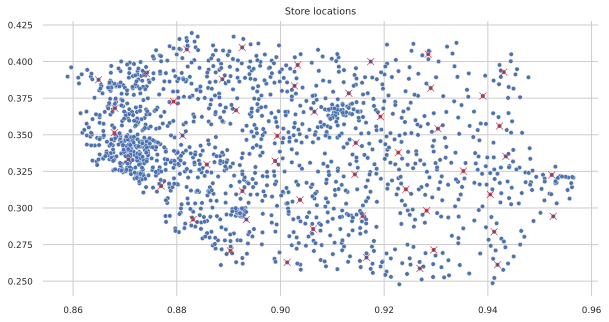

There are 50.0 stores placed


In [16]:
stores = coordinates[utils.vars(model, dtype=bool)]
seaborn.scatterplot(x = coordinates[:,0], y = coordinates[:,1], s=20)
seaborn.scatterplot(x = stores[:,0], y = stores[:,1], marker="x", color="red", s=50)
plt.title("Store locations"); plt.show()
print(f"There are {model.objVal} stores placed")

I was able to compute the solution for at least half the dataset in a reasonable time. \
About 50 stores are required to cover all of the cities.

### Model relaxation

In [17]:
%time model = solve(distances < 50, verbose=True, relaxed=True)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Fedora Linux 36 (Workstation Edition)")

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1459 rows, 1459 columns and 73047 nonzeros
Model fingerprint: 0x3cc0f0be
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 18 rows and 18 columns
Presolve time: 0.02s
Presolved: 1441 rows, 1441 columns, 71463 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 AA' NZ     : 1.024e+05
 Factor NZ  : 2.611e+05 (roughly 3 MB of memory)
 Factor Ops : 5.665e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual  

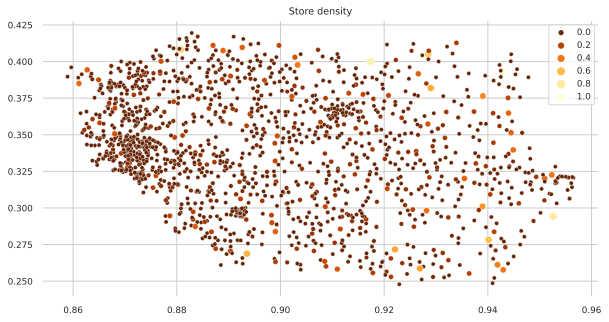

There are 47.40519295581441 stores placed


In [18]:
storiness = utils.vars(model, dtype=float)
seaborn.scatterplot(x = coordinates[:,0], y = coordinates[:,1], s=20, hue=storiness, size=storiness, palette="YlOrBr_r")
plt.title("Store density"); plt.show()
print(f"There are {model.objVal} stores placed")

The relaxed model is computed in half the time of the original. \
In the end we did get away with a little less overall storiness with our continous formulation, but we are not far off.

### Minimal distance per placement size
Unfortunately, I was unable to come up with a much better solution than simply checking different distance ranges since distance is not a variable of my linear program. \
Such experiment requires the dataset to be much smaller.

In [21]:
coordinates, distances, cities = utils.load_dataset(frac = 0.05, seed = 123).values()
len(cities)

148

In [22]:
print(
	solve(distances < 400).ObjVal,
	solve(distances < 350).ObjVal,
	solve(distances < 50).ObjVal,
)

1.0 2.0 41.0


Objective for D = 50 is 41 when considering only 5% of the full dataset.

In [23]:
pandas.set_option('display.max_columns', None)
experiments = [(d, int(solve(distances < d).ObjVal)) for d in range(40, 400)]
pandas.DataFrame(experiments, columns=["distance", "k"]).groupby("k").min().reset_index().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
k,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,20,22,24,25,26,27,28,30,32,35,36,38,40,41,42,43,45,47,48,50,53,56
distance,387,282,226,192,167,147,129,120,115,113,99,96,94,89,87,79,77,73,72,70,67,65,62,60,57,56,55,54,53,52,50,49,48,46,45,44,43,42,40


### Running time

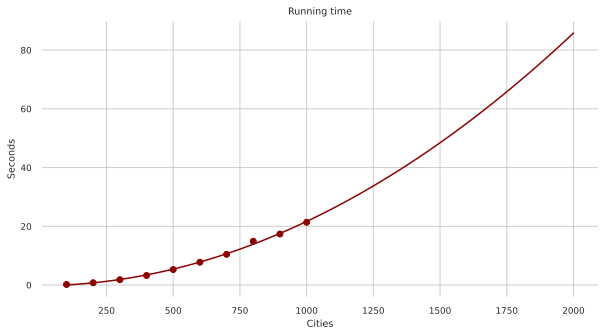

In [26]:
adjacent = tuple(utils.load_dataset(seed=123).values())[1] < 50
x = numpy.arange(10) * 100 + 100
y = [utils.timeit(lambda: solve(adjacent[:n, :n])) for n in x]

utils.polyplot(x, y, extrapolate=2.0, degree=2, color="darkred")
plt.xlabel('Cities')
plt.ylabel('Seconds')
plt.title('Running time')
plt.show()

# Excercise 2

### Linear program

Below is an implementation of the [Dantzig-Fulkerson-Johnson](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) linear program formulation for the metric traveling salesman problem. 

In [27]:
def findcycle(order, start = 0):
	cycle = [start]
	while cycle[0] != (next := order[cycle[-1]]):
		cycle.append(next)
	return cycle

def mincycle(order):
	unvisited = set(order)
	cycles = []
	while unvisited:
		start = unvisited.pop()
		cycle = findcycle(order, start)
		cycles.append(cycle)
		unvisited = unvisited.difference(cycle)
	return min(cycles, key=len)

def elimcycles(model, where):
	if where != GRB.Callback.MIPSOL:
		return

	X = model._vars
	C = utils.cycles(list(model.cbGetSolution(X).values()))

	Q = mincycle(C)
	if len(Q) < len(C):
		model.cbLazy(gp.quicksum(X[edge] for edge in product(Q, Q)) <= len(Q)-1)
		

def solve(A: numpy.ndarray[int, int], lazy = True, verbose = False):
	model = gp.Model()
	model.Params.OutputFlag = verbose
	
	V = numpy.arange(n := len(A))
	X = model._vars = model.addVars(*A.shape, vtype=GRB.BINARY)

	model.setObjective( gp.quicksum(X[edge] * A[edge] for edge in product(V, V)) )

	model.addConstrs( X[i, i] == 0 for i in range(n) )

	model.addConstrs( X.sum('*', j) == 1 for j in range(n) )
	model.addConstrs( X.sum(i, '*') == 1 for i in range(n) )

	if lazy:
		model.Params.LazyConstraints = 1
		model.optimize(elimcycles)
	else:
		powerset = utils.powerset(numpy.arange(n))
		model.addConstrs( gp.quicksum(X[edge] for edge in product(Q, Q)) <= len(Q) - 1 for Q in powerset if n != len(Q) >= 2 )
		model.optimize()
	return model

### Eager implementation
Model has all of the constraints enabled from the beginning. \
With this approach I was able to solve instances of at most 16 cities in a reasonable time.

In [28]:
data = coordinates, distances, cities = utils.load_dataset(frac=0.007, seed=123).values()
len(cities)

16

In [29]:
%time model = solve(distances, lazy=False, verbose=True)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Fedora Linux 36 (Workstation Edition)")

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 65566 rows, 256 columns and 4456704 nonzeros
Model fingerprint: 0x2e06f7f5
Variable types: 0 continuous, 256 integer (256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 4467.0000000
Presolve removed 16 rows and 16 columns (presolve time = 5s) ...
Presolve removed 16 rows and 16 columns
Presolve time: 6.35s
Presolved: 65550 rows, 240 columns, 3932400 nonzeros
Variable types: 0 continuous, 240 integer (240 binary)
Root relaxation presolved: 240 rows, 65790 columns, 3932640 nonzeros


Root simplex log...

Iteration    Objective       Primal 

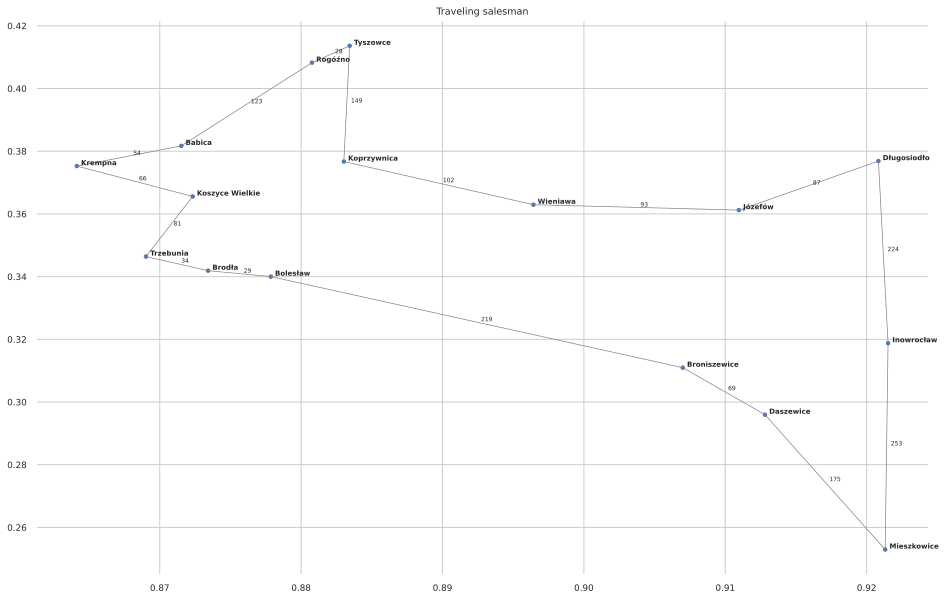

Value of the objective function is 1786


In [30]:
utils.graphplot(utils.edges(utils.vars(model)), *data, title='Traveling salesman')
print(f"Value of the objective function is {int(model.objVal)}")

### Lazy implementation
Each time a subcycle is detected we add an extra constraint to the model targetting that specific cycle. \
Lazy computation turned out to be quite efficient and thus allowed me to solve instances of up to an order of magnitude greater than before. 

In [20]:
data = coordinates, distances, cities = utils.load_dataset(frac = 0.06, seed = 123).values()
len(cities)

172

In [21]:
%time model = solve(distances, lazy=True, verbose=True)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Fedora Linux 36 (Workstation Edition)")

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 516 rows, 29584 columns and 59340 nonzeros
Model fingerprint: 0x02487f94
Variable types: 0 continuous, 29584 integer (29584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 172 rows and 172 columns
Presolve time: 0.03s
Presolved: 344 rows, 29412 columns, 58824 nonzeros
Variable types: 0 continuous, 29412 integer (29412 binary)

Root relaxation: objective 4.212000e+03, 275 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

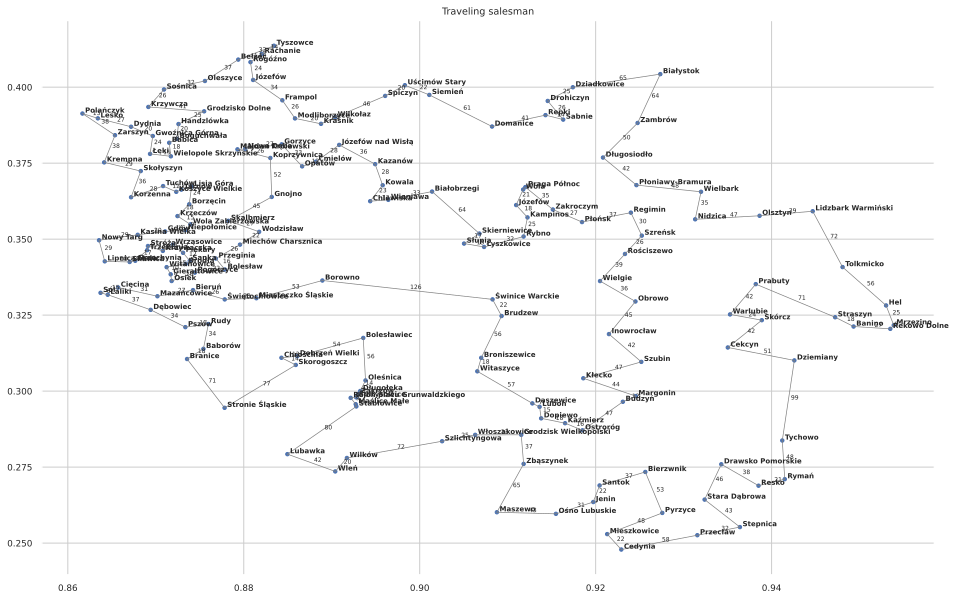

Value of the objective function is 5199


In [22]:
utils.graphplot(utils.edges(utils.vars(model)), *data, title='Traveling salesman')
print(f"Value of the objective function is {int(model.objVal)}")

# Excercise 3

### Christofides algorithm

Below implementation uses the [networkx](https://networkx.org/) library. \
The minimal weight matching implementation is claimed to be in $O(|V|^3)$ time.

In [31]:
def christofides(distances):
	G = nx.Graph()
	G.add_nodes_from(numpy.arange(len(distances)))
	for edge in combinations(G.nodes, 2):
		G.add_edge(*edge, weight=distances[edge])

	mst = nx.minimum_spanning_tree(G)
	ods = G.subgraph([v for v, degree in mst.degree if degree % 2])
	
	MG = nx.MultiGraph()
	MG.add_edges_from(mst.edges)
	MG.add_edges_from(nx.min_weight_matching(ods))
	return sum(distances[edge] for edge in utils.tour(MG))

### Christofides step by step

In [32]:
data = coordinates, distances, cities = utils.load_dataset(frac = 0.005, seed = 123).values()
len(cities)

10

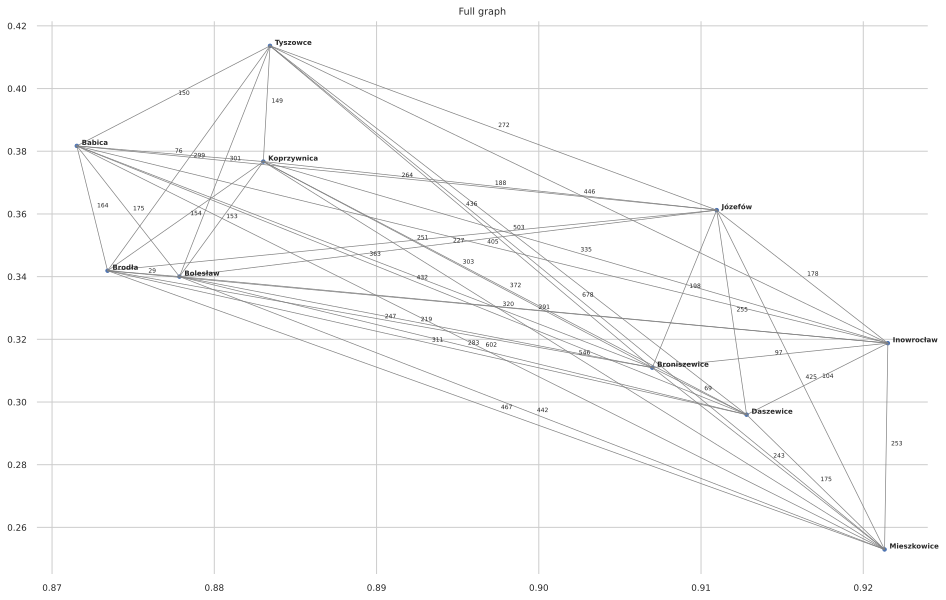

In [33]:
G = nx.Graph()
G.add_nodes_from(numpy.arange(n := len(cities)))
for edge in combinations(G.nodes, 2):
	G.add_edge(*edge, weight=distances[edge])
utils.graphplot(G.edges, *data, title=f"Full graph")

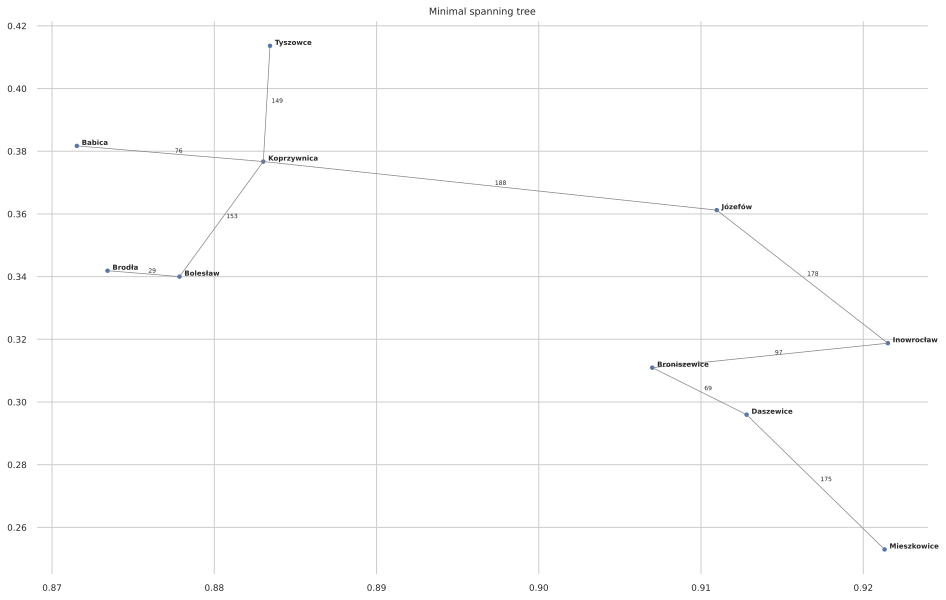

In [34]:
utils.graphplot((MST := nx.minimum_spanning_tree(G)).edges, *data, title="Minimal spanning tree")

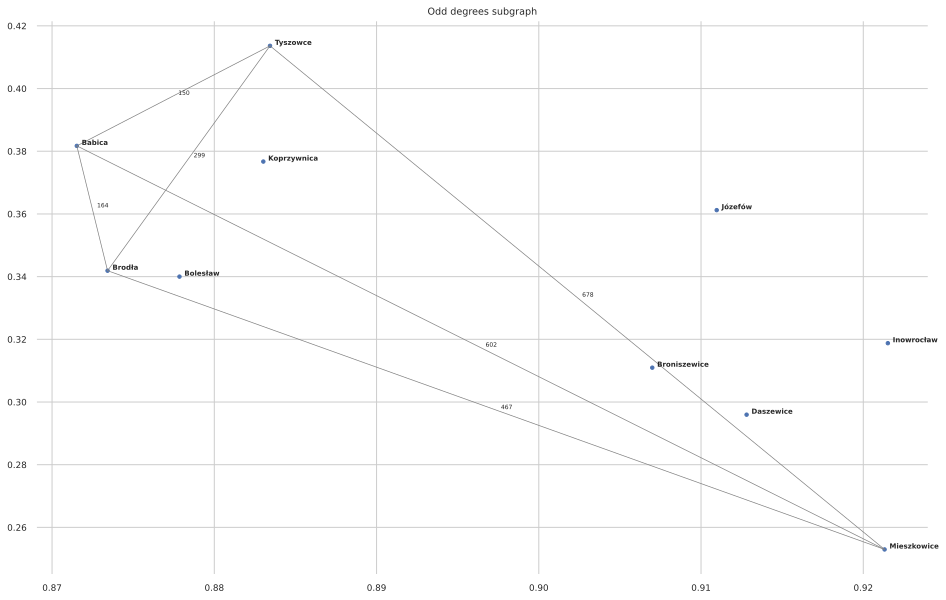

In [35]:
utils.graphplot((ODS := G.subgraph([v for v, degree in MST.degree if degree % 2])).edges, *data, title = "Odd degrees subgraph")

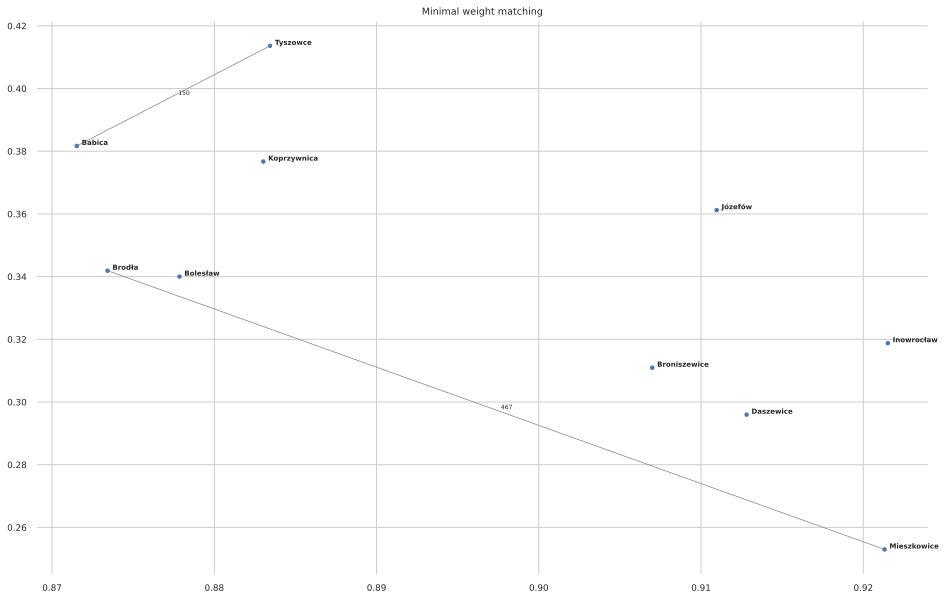

In [36]:
utils.graphplot((MWM := ODS.edge_subgraph(nx.min_weight_matching(ODS))).edges, *data, title="Minimal weight matching")

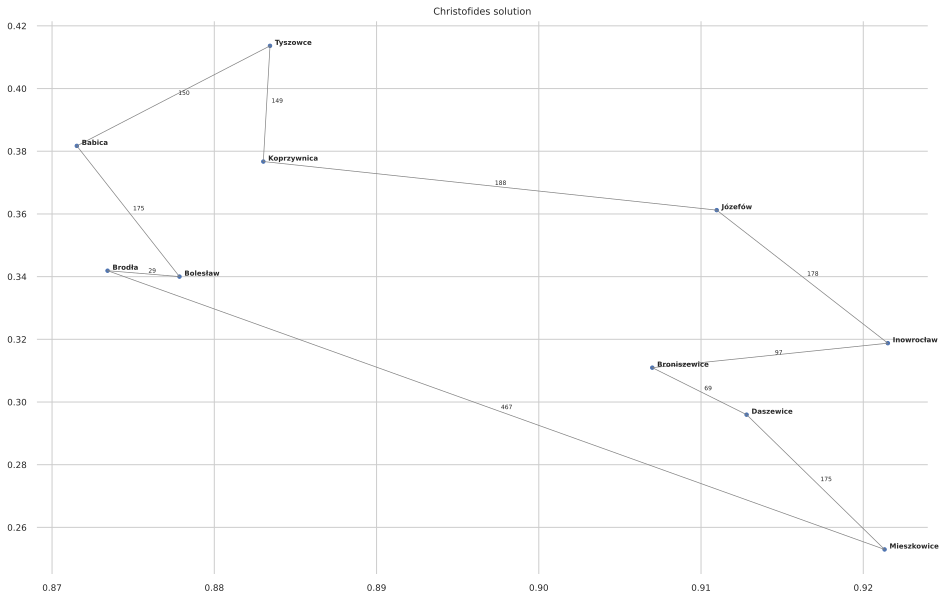

In [37]:
MG = nx.MultiGraph()
MG.add_edges_from(MST.edges)
MG.add_edges_from(MWM.edges)
utils.graphplot(utils.tour(MG), *data, title="Christofides solution")

### Efficiency and running time

In [38]:
data = coordinates, distances, cities = utils.load_dataset(frac = 0.06, seed = 123).values()
len(cities)

172

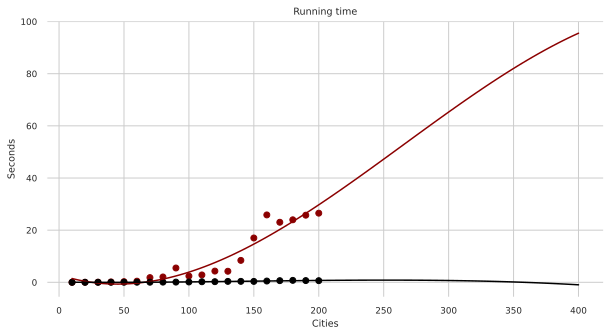

In [39]:
x = numpy.arange(20) * 10 + 10
y = [utils.timeit(lambda: solve(distances[:n, :n])) for n in x]
z = [utils.timeit(lambda: christofides(distances[:n, :n])) for n in x]

utils.polyplot(x, y, extrapolate=2.0, degree=3, color="darkred")
utils.polyplot(x, z, extrapolate=2.0, degree=3, color="black")
plt.xlabel('Cities')
plt.ylabel('Seconds')
plt.title('Running time')
plt.show()

Since our Christofides implementation works in polynomial time while the linear program approach is ultimately exponential this is pretty much the result we would expect. 

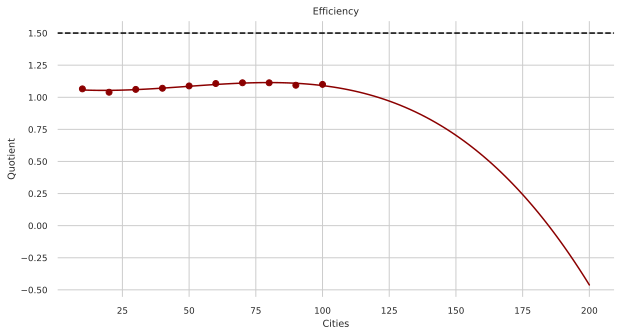

In [57]:
x = numpy.arange(15) * 10 + 10
y = [christofides(distances[:n, :n]) / solve(distances[:n, :n]).objVal for n in x]

utils.polyplot(x, y, extrapolate=2.0, degree=3, color="darkred")
plt.axhline(y=3/2, color='black', linestyle='--')
plt.xlabel('Cities')
plt.ylabel('Quotient')
plt.title('Efficiency')
plt.show()